In [184]:
using CSV
using Random
using StatsBase
using DataFrames
using Turing
using StatsPlots
using StatsFuns
using LaTeXStrings
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using ParetoSmooth
using ParetoSmoothedImportanceSampling
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

# 8.1 Building an interaction

Code 8.1

In [41]:
d = DataFrame(CSV.File("data/rugged.csv"))
dd = d[completecases(d, :rgdppc_2000),:]
dd[:,:log_gdp] = log.(dd.rgdppc_2000);
dd[:,:log_gdp_std] = dd.log_gdp / mean(dd.log_gdp)
dd[:,:rugged_std] = dd.rugged / maximum(dd.rugged);

Code 8.2

In [42]:
r̄ = mean(dd.rugged_std)

@model function model_m8_1(rugged_std, log_gdp_std)
    σ ~ Exponential()
    a ~ Normal(1, 1)
    b ~ Normal(0, 1)
    μ = @. a + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

model_m8_1 (generic function with 2 methods)

Code 8.3

In [43]:
m8_1_p = sample(model_m8_1(dd.rugged_std, dd.log_gdp_std), Prior(), 1000)
m8_1_p_df = DataFrame(m8_1_p);

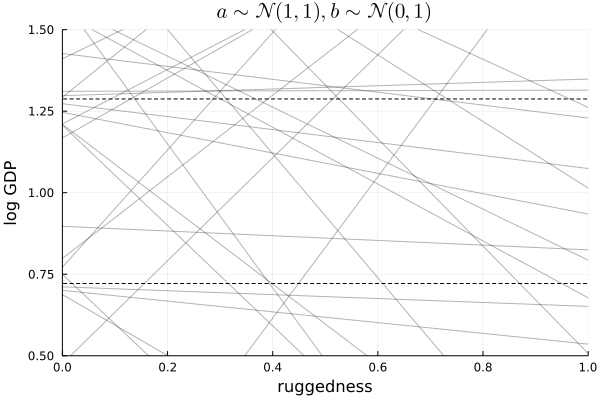

In [63]:
rugged_seq = range(-0.1, 1.1; length=30)
μ = link(m8_1_p_df, (r, x) -> r.a + r.b*(x - r̄), rugged_seq)
μ = hcat(μ...)

p = plot(
    xlim=(0, 1),
    ylim=(0.5, 1.5),
    title=L"a \sim \mathcal{N}(1,1), b \sim \mathcal{N}(0, 1)",
    xlab="ruggedness", ylab="log GDP",
)
hline!(collect(extrema(dd.log_gdp_std)); c=:black, s=:dash)
for μ₀ ∈ first(eachrow(μ), 50)
    plot!(rugged_seq, μ₀; c=:black, alpha=0.3)
end
p

Code 8.4

In [67]:
mean(abs.(m8_1_p_df.b) .> 0.6)

0.565

Code 8.5

In [68]:
r̄ = mean(dd.rugged_std)

@model function model_m8_1a(rugged_std, log_gdp_std)
    σ ~ Exponential()
    a ~ Normal(1, 0.1)
    b ~ Normal(0, 0.3)
    μ = @. a + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_1 = sample(model_m8_1a(dd.rugged_std, dd.log_gdp_std), NUTS(), 1000)
m8_1_df = DataFrame(m8_1);

Code 8.6

In [69]:
precis(m8_1_df)

┌───────┬──────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%      50%   94.5%   histogram │
├───────┼──────────────────────────────────────────────────────┤
│     a │ 0.9997  0.0108   0.9826   0.9998  1.0174   ▁▁▄██▄▁▁▁ │
│     b │  0.001  0.0536  -0.0815  -0.0002  0.0872    ▁▁▄██▄▁▁ │
│     σ │ 0.1382  0.0078   0.1266   0.1379  0.1516  ▁▁▄▇█▇▄▂▁▁ │
└───────┴──────────────────────────────────────────────────────┘


Code 8.7

In [72]:
dd[:,:cid] = @. ifelse(dd.cont_africa == 1, 1, 2);

Code 8.8

In [74]:
@model function model_m8_2(rugged_std, cid,  log_gdp_std)
    σ ~ Exponential()
    a ~ MvNormal([1, 1], 0.1)
    b ~ Normal(0, 0.3)
    μ = @. a[cid] + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_2 = sample(model_m8_2(dd.rugged_std, dd.cid,  dd.log_gdp_std), NUTS(), 1000)
m8_2_df = DataFrame(m8_2);

Code 8.9

In [101]:
# Compute log likelihoods for both models
fun = (r, (x,y)) -> normlogpdf(r.a + r.b * (x - r̄), r.σ, y)
m8_1_ll = link(m8_1_df, fun, zip(dd.rugged_std, dd.log_gdp_std))
m8_1_ll = hcat(m8_1_ll...)

# need DF with a as a vector of both a[1] and a[2]
df = DataFrame(m8_2_df)
df[!,:a] = collect.(zip(m8_2_df.:"a[1]", m8_2_df.:"a[2]"))

fun = (r, (x,c,y)) -> normlogpdf(r.a[c] + r.b * (x - r̄), r.σ, y)
m8_2_ll = link(df, fun, zip(dd.rugged_std, dd.cid, dd.log_gdp_std))
m8_2_ll = hcat(m8_2_ll...);

compare([m8_1_ll, m8_2_ll], :waic, mnames=["m8.1", "m8.2"])

,models,WAIC,lppd,SE,dWAIC,dSE,pWAIC,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m8.2,-252.2,-260.52,14.84,0.0,0.0,4.18,1.0
2,m8.1,-188.9,-193.98,12.95,63.3,14.7,2.53,0.0


Code 8.10

In [91]:
precis(m8_2_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%     histogram │
├───────┼─────────────────────────────────────────────────────────┤
│  a[1] │  0.8805  0.0169   0.8538   0.8802  0.9066  ▁▁▁▃▆██▆▄▂▁▁ │
│  a[2] │  1.0492  0.0103   1.0329   1.0494  1.0662       ▁▁▄██▃▁ │
│     b │ -0.0465  0.0453  -0.1146  -0.0465  0.0267        ▁▃██▃▁ │
│     σ │  0.1141  0.0063   0.1042   0.1141  0.1243     ▁▁▂▆██▄▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


Code 8.11

In [107]:
PI(map(r -> r[1] - r[2], df.a))

2-element Vector{Float64}:
 -0.20193898335654065
 -0.1384096203949567

Code 8.12

In [158]:
rugged_seq = range(-0.1, 1.1, length=30)
africa     = link(df, (r, x) -> r.a[1] + r.b*(x-r̄), rugged_seq)
africa     = hcat(africa...)'
not_africa = link(df, (r, x) -> r.a[2] + r.b*(x-r̄), rugged_seq)
not_africa = hcat(not_africa...)'

μₐ = mean.(eachrow(africa))
μₙ = mean.(eachrow(not_africa))
PIₐ = PI.(eachrow(africa))
PIₐ = vcat(PIₐ'...)
PIₙ = PI.(eachrow(not_africa))
PIₙ = vcat(PIₙ'...);

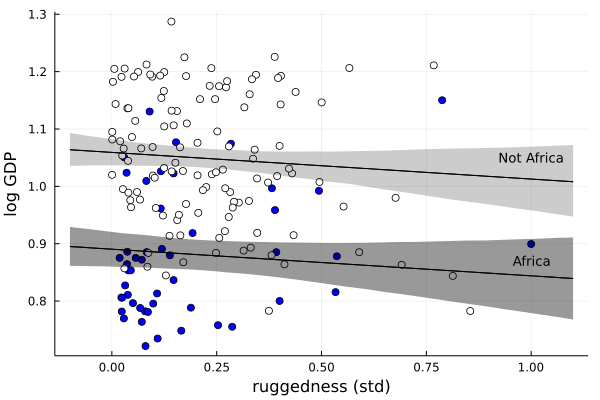

In [178]:
p = plot(xlab="ruggedness (std)", ylab="log GDP")
scatter!(dd.rugged_std[dd.cid.==1], dd.log_gdp_std[dd.cid.==1], c=:blue)
scatter!(dd.rugged_std[dd.cid.==2], dd.log_gdp_std[dd.cid.==2], c=:white)

plot!(rugged_seq, [μₐ, μₐ], c=:black, fillrange=PIₐ, fillalpha=0.4)
plot!(rugged_seq, [μₙ, μₙ], c=:black, fillrange=PIₙ, fillalpha=0.2)
annotate!([
    (1, 0.87, ("Africa", 9)),
    (1, 1.05, ("Not Africa", 9))
])

Code 8.13

In [179]:
@model function model_m8_3(rugged_std, cid,  log_gdp_std)
    σ ~ Exponential()
    a ~ MvNormal([1, 1], 0.1)
    b ~ MvNormal([0, 0], 0.3)
    μ = @. a[cid] + b[cid] * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_3 = sample(model_m8_3(dd.rugged_std, dd.cid,  dd.log_gdp_std), NUTS(), 1000)
m8_3_df = DataFrame(m8_3);

Code 8.14

In [180]:
precis(m8_3_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%     histogram │
├───────┼──────────────────────────────────────────────────────────┤
│  a[1] │   0.887  0.0164   0.8608   0.8871   0.9124   ▁▂▄▇█▇▅▂▁▁▁ │
│  a[2] │   1.051  0.0097   1.0356   1.0508   1.0671  ▁▁▂▄▆██▇▄▃▁▁ │
│  b[1] │  0.1348  0.0752   0.0108    0.135   0.2642    ▁▁▃▇██▄▂▁▁ │
│  b[2] │ -0.1455   0.056  -0.2354  -0.1462  -0.0569     ▁▁▄██▅▁▁▁ │
│     σ │  0.1115  0.0064   0.1015   0.1114   0.1217     ▁▁▄▆█▅▂▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


Code 8.15

In [183]:
df3 = DataFrame(m8_3_df)
df3[!,:a] = collect.(zip(m8_3_df.:"a[1]", m8_3_df.:"a[2]"))
df3[!,:b] = collect.(zip(m8_3_df.:"b[1]", m8_3_df.:"b[2]"))

fun = (r, (x,c,y)) -> normlogpdf(r.a[c] + r.b[c] * (x - r̄), r.σ, y)
m8_3_ll = link(df3, fun, zip(dd.rugged_std, dd.cid, dd.log_gdp_std))
m8_3_ll = hcat(m8_3_ll...);

compare([m8_1_ll, m8_2_ll, m8_3_ll], :psis, mnames=["m8.1", "m8.2", "m8.3"])

,models,PSIS,lppd,SE,dPSIS,dSE,pPSIS,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m8.3,-259.9,-269.19,14.6,0.0,0.0,5.0,0.97
2,m8.2,-252.7,-260.52,14.77,7.2,6.62,4.18,0.03
3,m8.1,-189.2,-193.98,12.93,70.7,14.9,2.53,0.0


Code 8.16

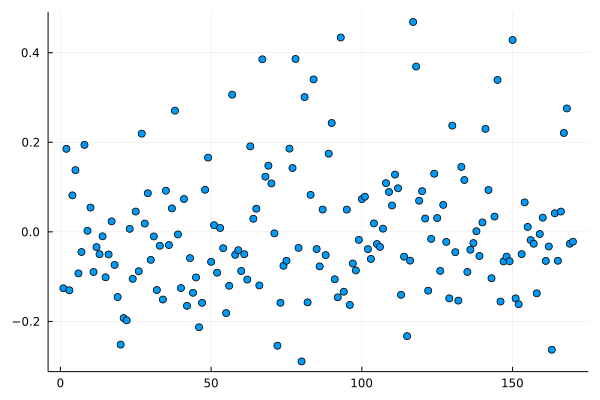

In [190]:
t = m8_3_ll'
m8_3_t = collect(reshape(t, size(t)..., 1))
PSIS_m8_3 = psis_loo(m8_3_t)
scatter(PSIS_m8_3.pointwise(:pareto_k))

Code 8.17

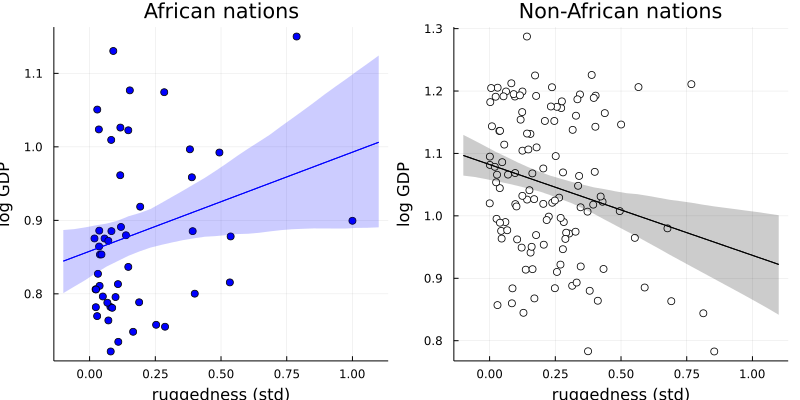

In [202]:
# build data
africa     = link(df3, (r, x) -> r.a[1] + r.b[1]*(x-r̄), rugged_seq)
africa     = hcat(africa...)'
not_africa = link(df3, (r, x) -> r.a[2] + r.b[2]*(x-r̄), rugged_seq)
not_africa = hcat(not_africa...)'

μₐ = mean.(eachrow(africa))
μₙ = mean.(eachrow(not_africa))
PIₐ = PI.(eachrow(africa))
PIₐ = vcat(PIₐ'...)
PIₙ = PI.(eachrow(not_africa))
PIₙ = vcat(PIₙ'...);

# plot Africa, cid=1
p1 = plot(xlab="ruggedness (std)", ylab="log GDP", title="African nations")
scatter!(dd.rugged_std[dd.cid.==1], dd.log_gdp_std[dd.cid.==1], c=:blue)
plot!(rugged_seq, [μₐ, μₐ], c=:blue, fillrange=PIₐ, fillalpha=0.2)

# plot non Africa, cid=2
p2 = plot(xlab="ruggedness (std)", ylab="log GDP", title="Non-African nations")
scatter!(dd.rugged_std[dd.cid.==2], dd.log_gdp_std[dd.cid.==2], c=:white)
plot!(rugged_seq, [μₙ, μₙ], c=:black, fillrange=PIₙ, fillalpha=0.2)

plot(p1, p2, size=(800, 400))

# 8.2 Symmetry of interations